In [37]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")


import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss, TiDE_forward


cuda is available


In [38]:
import torch
import torch.nn.functional as F
from policy import PolicyNN

# ── 모델 설정 ─────────────────────────────────────────
P = 50
window = 50
past_input_dim = 6
future_input_dim = 6
output_dim = 1
hidden_dim = 64
n_layers = 3
dropout_p = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 모델 불러오기 ─────────────────────────────────────
model = PolicyNN(
    past_input_dim=past_input_dim,
    future_input_dim=future_input_dim,
    output_dim=output_dim,
    p=P,
    window=window,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    dropout_p=dropout_p
).to(device)

model.load_state_dict(torch.load(
    "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/policy_model_0717_cutdata_lr1e-4_3L_64H_s1_c1.pth",
    map_location=device
))
model.eval()



PolicyNN(
  (input_layer): Linear(in_features=600, out_features=64, bias=True)
  (input_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (norm_layers): ModuleList(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=64, out_features=50, bias=True)
)

In [39]:
import pandas as pd

params = []

for name, param in model.named_parameters():
    param_np = param.detach().cpu().numpy()
    params.append({
        "name": name,
        "shape": tuple(param_np.shape),
        "mean": param_np.mean(),
        "std": param_np.std(),
        "min": param_np.min(),
        "max": param_np.max()
    })

df = pd.DataFrame(params)
print(df)


                     name      shape      mean       std       min       max
0      input_layer.weight  (64, 600) -0.000221  0.026432 -0.273152  0.252538
1        input_layer.bias      (64,) -0.001405  0.030872 -0.088589  0.067868
2         input_ln.weight      (64,)  0.707855  0.257694 -0.299752  1.060120
3           input_ln.bias      (64,) -0.043259  0.062466 -0.202910  0.162286
4  hidden_layers.0.weight   (64, 64)  0.006349  0.068959 -0.367846  0.534822
5    hidden_layers.0.bias      (64,)  0.003940  0.059138 -0.129492  0.107354
6    norm_layers.0.weight      (64,)  0.590930  0.348376 -0.010112  1.108755
7      norm_layers.0.bias      (64,)  0.085047  0.053000 -0.005077  0.227810
8     output_layer.weight   (50, 64) -0.002315  0.062365 -0.200552  0.212502
9       output_layer.bias      (50,) -0.014381  0.050682 -0.118775  0.085305


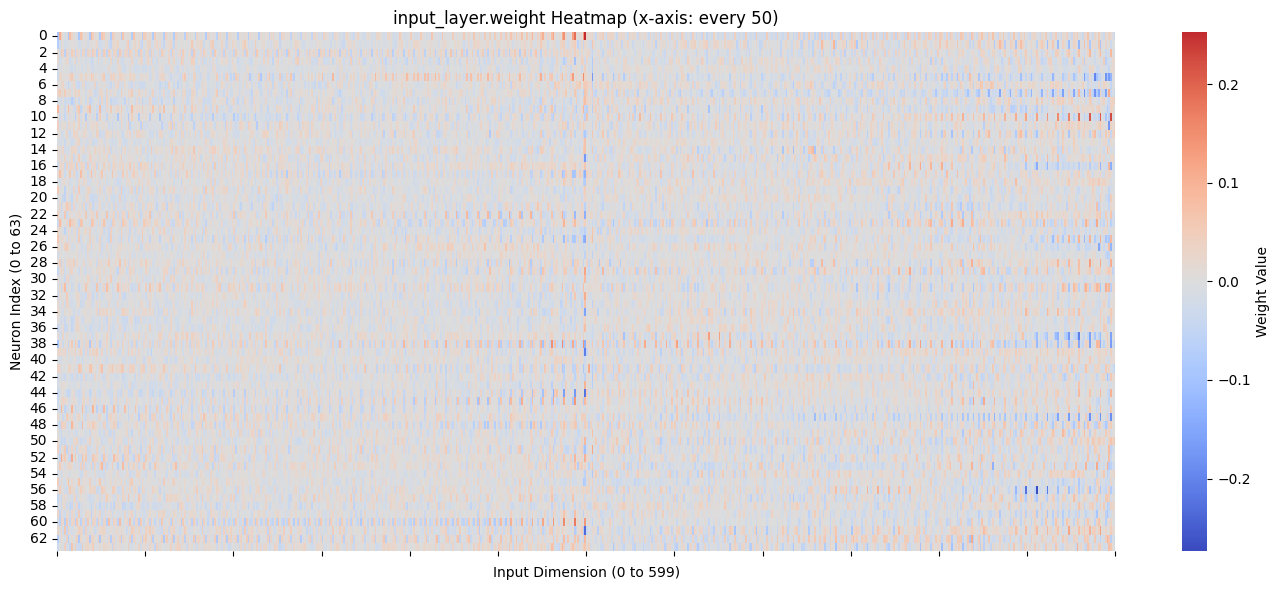

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

save_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725"
os.makedirs(save_dir, exist_ok=True)

# state_dict에서 weight와 bias 추출
sd = model.state_dict()
w = sd['input_layer.weight'].detach().cpu().numpy()  # (64, 600)
b = sd['input_layer.bias'].detach().cpu().numpy()    # (64,)

# CSV 저장
pd.DataFrame(w).to_csv("99_input_layer_weight.csv", index=False)
pd.DataFrame(b, columns=["bias"]).to_csv("99_input_layer_bias.csv", index=False)

# 1. CSV 불러오기
df_w = pd.read_csv("99_input_layer_weight.csv")
w = df_w.values  # shape: (64, 600)

# 2. Heatmap 시각화
plt.figure(figsize=(14, 6))
sns.heatmap(w, cmap='coolwarm', center=0, cbar_kws={'label': 'Weight Value'})

# 3. x축: 0부터 600까지 50 단위 눈금 설정
xticks = np.arange(0, 601, 50)
plt.xticks(xticks)

plt.xlabel("Input Dimension (0 to 599)")
plt.ylabel("Neuron Index (0 to 63)")
plt.title("input_layer.weight Heatmap (x-axis: every 50)")
plt.tight_layout()
plt.show()


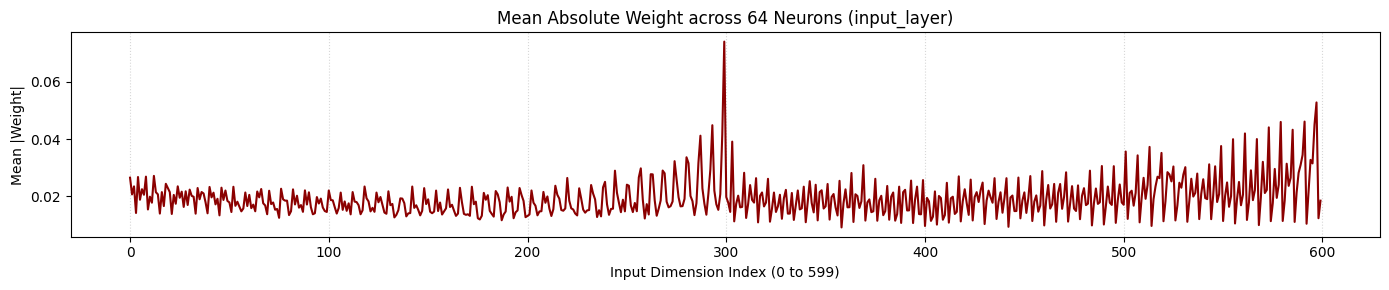

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. CSV 불러오기
df_w = pd.read_csv("99_input_layer_weight.csv")
w = df_w.values  # shape: (64, 600)

# 2. 절댓값 평균 계산
abs_mean_per_input_dim = np.abs(w).mean(axis=0)  # shape: (600,)

# 3. 시각화
plt.figure(figsize=(14, 3))
plt.plot(abs_mean_per_input_dim, color='darkred')
plt.xlabel("Input Dimension Index (0 to 599)")
plt.ylabel("Mean |Weight|")
plt.title("Mean Absolute Weight across 64 Neurons (input_layer)")
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


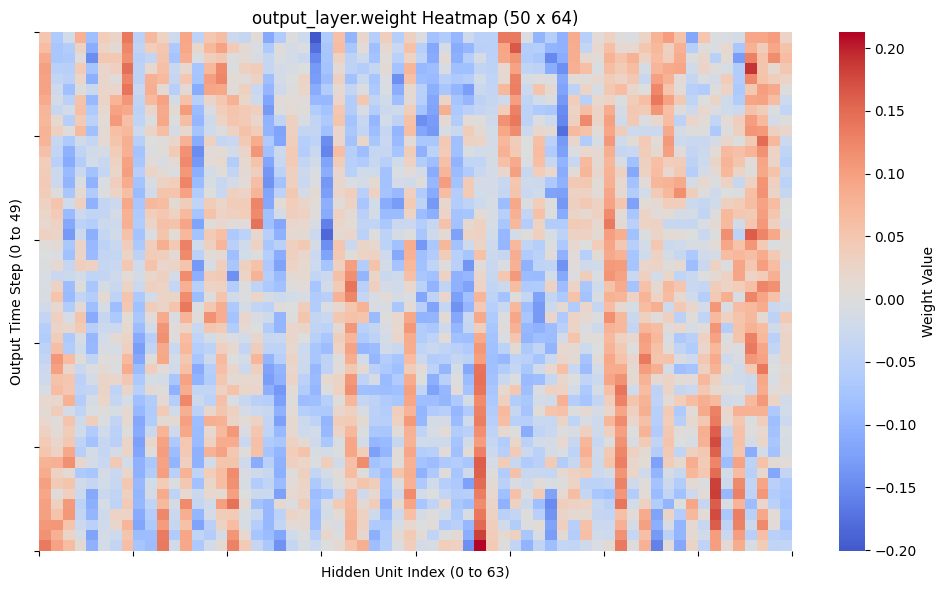

In [43]:
# 출력층 weight 추출 후 저장
output_w = model.state_dict()['output_layer.weight'].detach().cpu().numpy()  # shape: (50, 64)
pd.DataFrame(output_w).to_csv("99_output_layer_weight.csv", index=False)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. CSV 불러오기
df_out = pd.read_csv("output_layer_weight.csv")
w_out = df_out.values  # shape: (50, 64)

# 2. Heatmap 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(w_out, cmap='coolwarm', center=0, cbar_kws={'label': 'Weight Value'})

# 3. x축: hidden unit index (0~63), 8단위 tick
plt.xticks(np.arange(0, 65, 8))

# 4. y축: output timestep (0~49), 10단위 tick
plt.yticks(np.arange(0, 51, 10))

plt.xlabel("Hidden Unit Index (0 to 63)")
plt.ylabel("Output Time Step (0 to 49)")
plt.title("output_layer.weight Heatmap (50 x 64)")
plt.tight_layout()
plt.show()

